## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./examples/undistort_chessboard.png "Undistorted Chessboard"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video_output.mp4 "Video"


## Rubric ponits

Here I will consider the rubric points individually and describe how I addressed each point in my implementation.

### Imports

In [199]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

### Camera Calibration

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function. Below is the code and followed by that is the result that I obtained:

In [200]:
def cal_camera(image_names):
    """
    Takes an array of image names. These images are used
    for calibrating the camera. 
    The output is the return val, camera matrix, distortion 
    coefficients and rotation and translation vectors describing
    the position of the camera in the world
    """
    images_new = []
    nx = 9
    ny = 6
    count = 0

    objpoints = []
    imgpoints = []
    
    for fname in image_names:
        img = mpimg.imread(fname)
        
        objp = np.zeros((ny*nx, 3), np.float32)
        objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
            images_new.append(fname)

    img = mpimg.imread(image_names[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1],None,None)
    
    return ret, mtx, dist, rvecs, tvecs

def dis_correct(img, ret, mtx, dist, rvecs, tvecs):
    """
    Undistorts the given image using camera coefficients
    and returns the image
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    return undist

Text(0.5, 1.0, 'Undistorted Image')

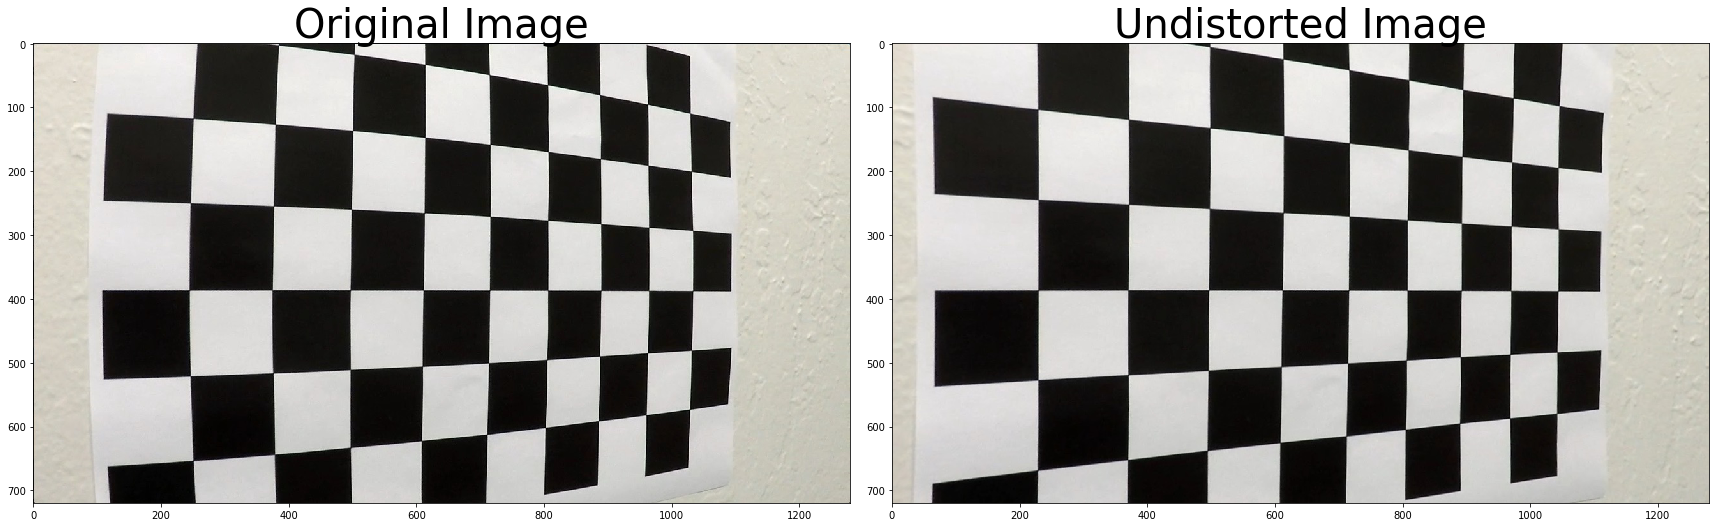

In [201]:
cal_images_folder_path = 'cal_images/calibration*'
image_names = glob.glob(cal_images_folder_path)
arr = cal_camera(image_names)
img = mpimg.imread(image_names[0])
undist = dis_correct(img, *tuple(arr))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(undist, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=40)

### Distortion Correction:

After computing the camera matrix and the distortion coeffecients in the previous step, we apply them to one of the test images below. We can see that the car at the right edge of the image which was slightly deformed, is now undistorted. Distortion takes place at the edge of the lens because of various reasons and hence undistortion becomes necessary. The following is the code and the result

Text(0.5, 1.0, 'Undistorted Image')

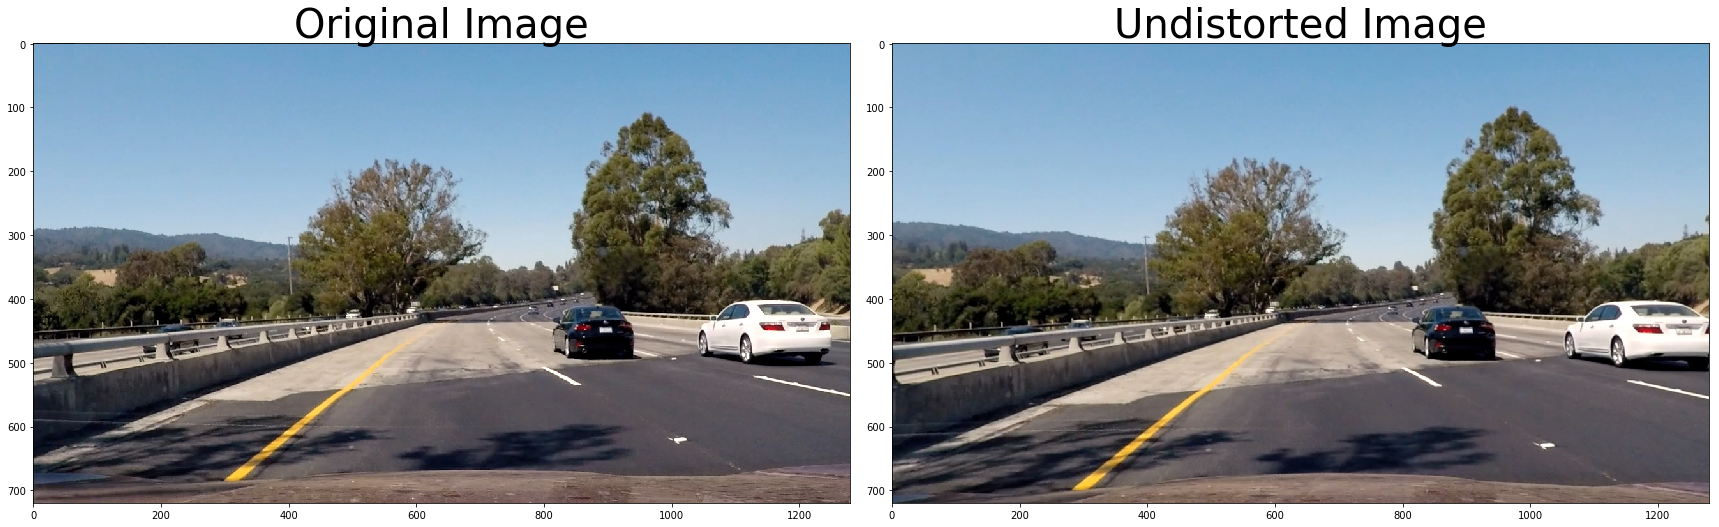

In [237]:
test_images_folder_path = 'test_images/*'
images_test = glob.glob(test_images_folder_path)
image = mpimg.imread(images_test[2])
undist = dis_correct(image, *tuple(arr))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(undist, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=40)

### Binary Thresholding

This step involves binarizing the image so that later we can use a region of interest mask and the only activated pixels would be the lane lines. For this step I convert the image to *HLS* format. I then use the Sobel operator's *x* gradient on the *L* channel (lightness). The *L* channel gives particularly good results for yellow lane lines which cannot be achieved if merely *RGB* respresentation is used. I then threshold the gradient output with the hyperparams provided (currently set to low=170, high=255). I then threshold the *S* channel with another set of thresholds to capture values that are missed by the previous steps and return the binary OR output of the two thresholded arrays. The following is the code and then an example output.

In [238]:
def thresold_binary(img, s_thresh=(170, 255), sx_thresh=(25, 100), v_thresh=(225, 255)):
    
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    v_channel = hsv[:,:,2]
    
    sobel_kernel = 3;
    gaussian_ksize = 9;
    l_channel = cv2.GaussianBlur(l_channel, (gaussian_ksize, gaussian_ksize), 0)
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold color channel
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (v_binary == 1)] = 1
    
    return combined_binary

Text(0.5, 1.0, 'Binary Thresholded Image')

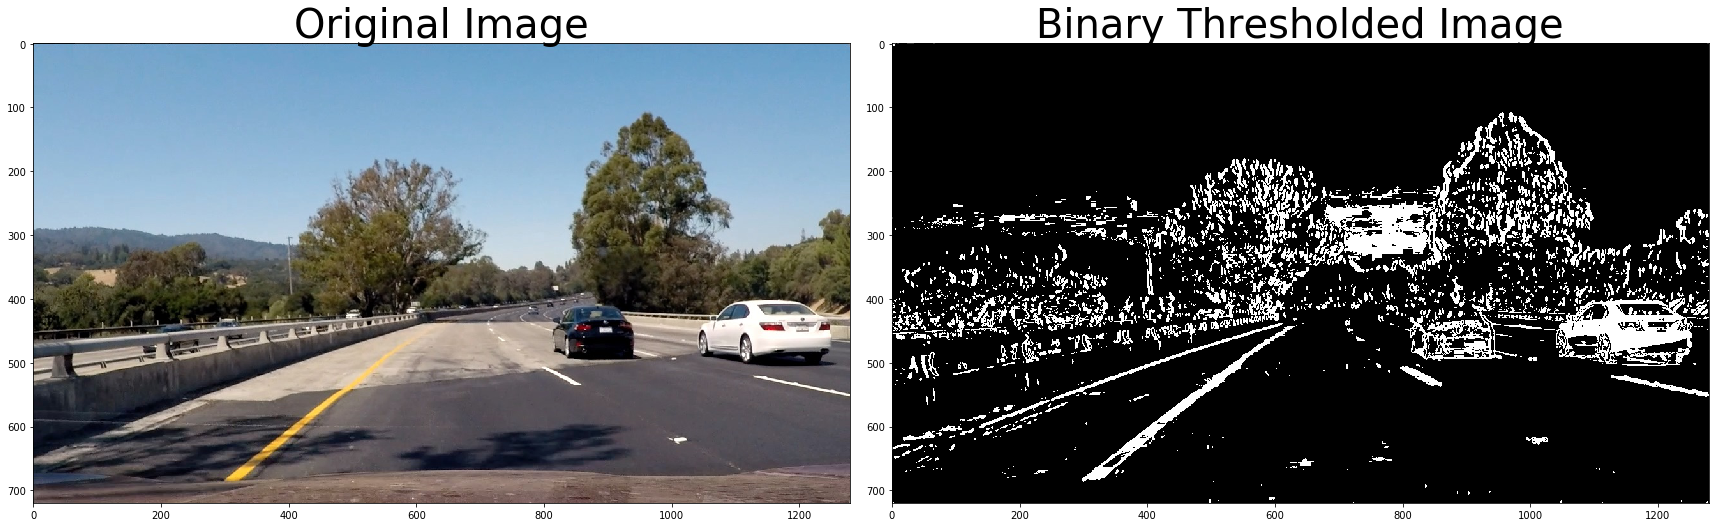

In [239]:
bin_thresh = thresold_binary(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(bin_thresh, cmap='gray')
ax2.set_title('Binary Thresholded Image', fontsize=40)

### Image Warping

This step involved warping an image to a bird's eye view of the road. This will help us in fitting the polynomial later so that I can unwarp it back to the original image to identify the lane.

In [240]:
def warp_img(img, vertices, offset = 350):
    """
    Warps the given image to a birds eye view of the image
    using the camera coefficients
    """
    # Convert undistorted image to grayscale
    if(len(img.shape) == 3):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(vertices)
    src = src.reshape((-1,1,2))
  
    dst = np.float32([[offset, 0], [img_size[0] - offset, 0], 
                                 [img_size[0]-offset, img_size[1]], 
                                 [offset, img_size[1]]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv

Text(0.5, 1.0, 'Warped Image')

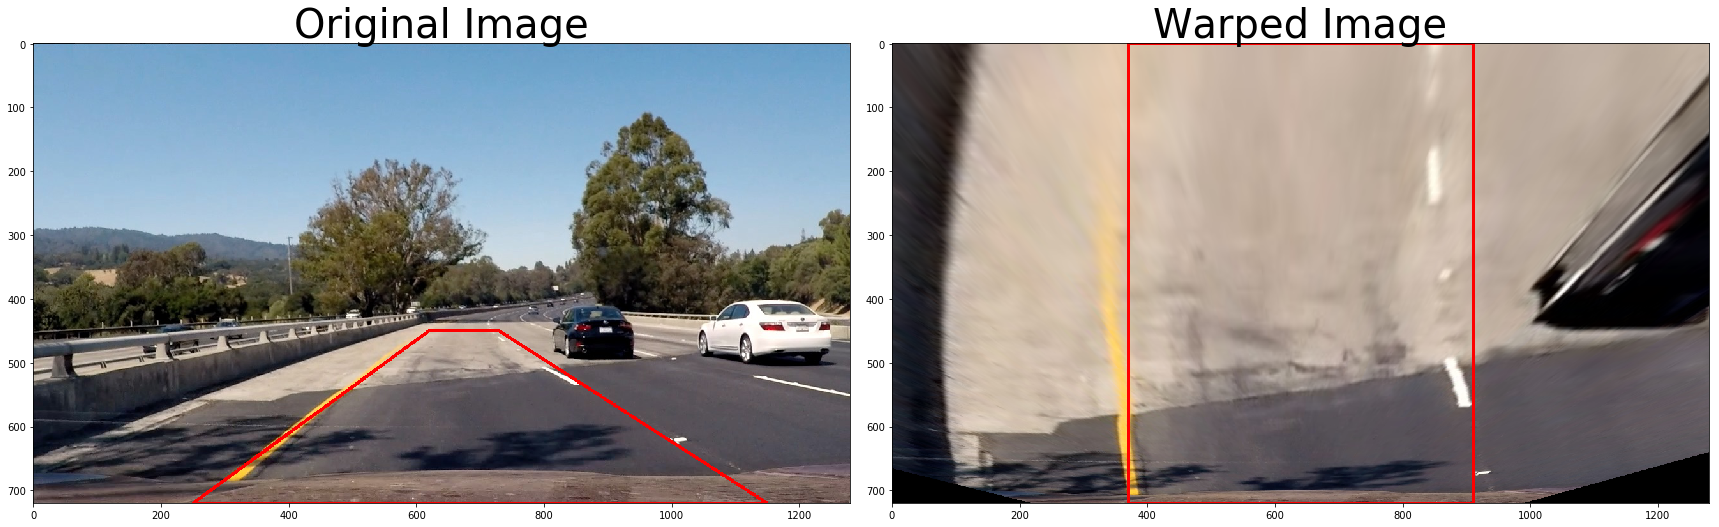

In [241]:
vertices = [[620, 450], [730, 450], [1150, image.shape[0]], [250, image.shape[0]]]
src = np.float32(vertices)
src = src.reshape((-1,1,2))
offset = 370
img_size = (img.shape[1], img.shape[0])
dst = np.int32([[offset, 0], [img_size[0] - offset, 0], 
                                 [img_size[0]-offset, img_size[1]], 
                                 [offset, img_size[1]]])
warped, M, Minv = warp_img(image, vertices, offset=offset)
warped_bin_thresh, M, Minv = warp_img(bin_thresh, vertices, offset=offset)

image_lines = np.copy(image)
image_lines = cv2.polylines(image_lines, np.int32([src]), True, (255,0,0), 4)
warped_lines = np.copy(warped)
warped_lines = cv2.polylines(warped_lines, np.int32([dst]), True, (255,0,0), 4)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image_lines)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped_lines, cmap='gray')
ax2.set_title('Warped Image', fontsize=40)

### Region of interest masking

In this step I try to extract the area from the image that predominantly has only lane line pixels activated. It doesn't work perfectly but it is enough to reduce the number of pixels in one column so that it doesn't create a false negative peak in the histogram step

In [242]:
# Takes only binary images
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    
    ignore_mask_color = 1
    
    vertices = np.int32(vertices)
        
    #filling pixels inside the polygon defined by "vertices" with the fill color
    vertices = vertices.reshape((-1,1,2))

    cv2.fillPoly(mask, [vertices], ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    img = cv2.bitwise_and(img, mask)
    
    return img

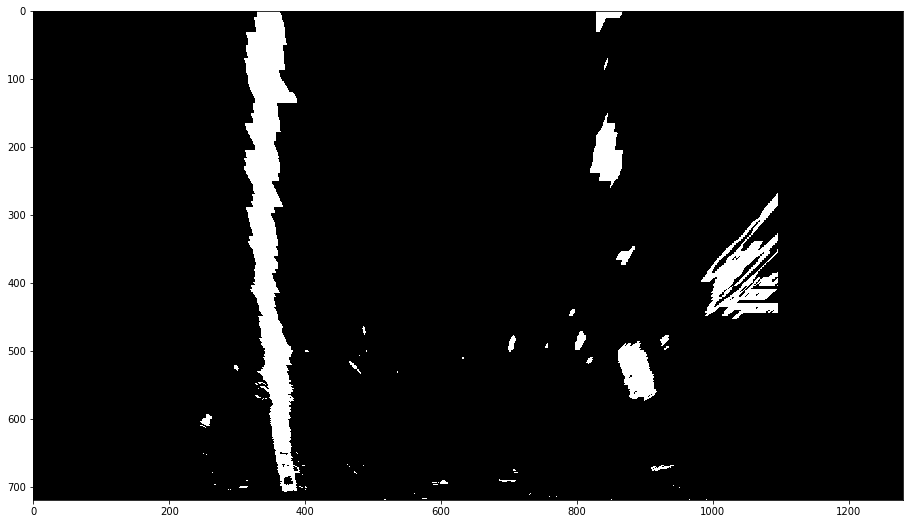

In [243]:
vertices_roi = [[offset / 2, 0], [img_size[0] - offset / 2, 0], 
                             [img_size[0]-offset / 2, img_size[1]], 
                             [offset / 2, img_size[1]]]


warped_roi = region_of_interest(warped_bin_thresh, vertices_roi)
plt.figure(figsize=(24, 9))
plt.imshow(warped_roi, cmap='gray')

### Identify lane line pixels and fit polynomial

The warped binary image with the correct region of interest can then be used to fit the polynomial on. The way I have done this by adding all the values in the each column to create a one dimentional histogram of the image. This will enable us to approximately identify the location of the left and right lane lines. I have then used a sliding window from that position that goes upwards recentering the window at each step depending on the number of pixels found within the window margin. 

The `search_aroud_poly` function below fits a new polynomial by searching in the neighbourhood of the previous frame's polynomial. We believe that the polynomial doesn't change much with each frame and we can avoid a lot of unnecessary compute if we use the function below rather than using the sliding window each time.

In [244]:
def find_lane_pixels(binary_warped, margin = 100):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.extend(good_left_inds)
        right_lane_inds.extend(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def get_fit_coef(binary_warped, margin = 100):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, margin)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit


def search_around_poly(binary_warped, left_fit_prev, right_fit_prev, margin = 100):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
                    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
                    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
                    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
                    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))
    
    # Again, extract left and right line pixel positions
    # pixel ids using the masked array
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ###Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds


def draw_fitted_lane_lines(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, margin=100):    
    ## Visualization ##
    img_shape = binary_warped.shape
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # pixel ids using the masked array
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
      
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    ###Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    # The flipud is used so that the corners of the polygon are in clockwise order
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.1, 0)

    # Plot the polynomial lines onto the image
    cv2.polylines(result,[np.array(np.int32(np.transpose(np.vstack([left_fitx, ploty]))))],False,(0,255,255), lineType=cv2.CV_AA)
    cv2.polylines(result,[np.array(np.int32(np.transpose(np.vstack([right_fitx, ploty]))))],False,(0,255,255), lineType=cv2.CV_AA)
    
    plt.figure(figsize=(24, 9))
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='green')
    plt.plot(right_fitx, ploty, color='green')
    
    return result

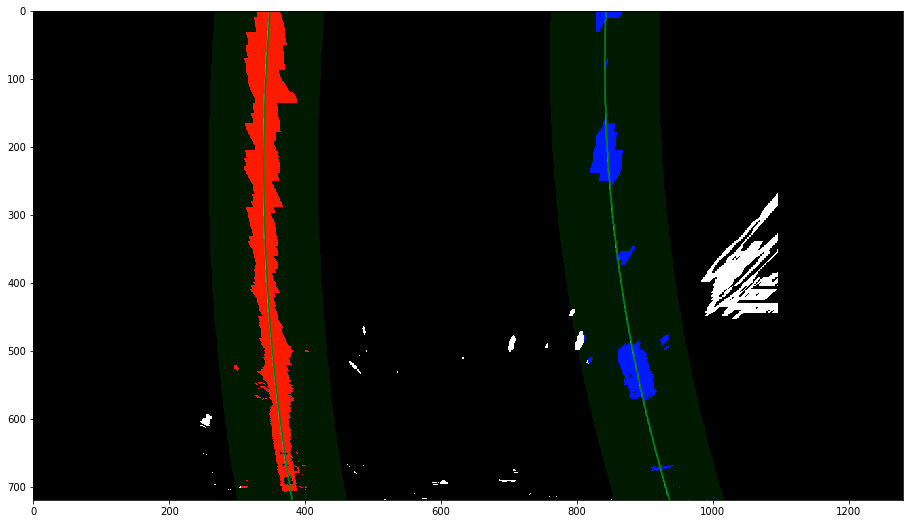

In [245]:
result = None

left_ftit_prev, right_fit_prev = get_fit_coef(warped_roi, margin = 70)
        
left_fit, right_fit, left_lane_inds, right_lane_inds = search_around_poly(warped_roi, left_fit_prev, right_fit_prev, margin = 70)

draw_fitted_lane_lines(warped_roi, left_fit, right_fit, left_lane_inds, right_lane_inds, margin=80);


### Radius of curvature and sway

The function below calculates the radius of curvature of the lane lines detected. We assume that the center of the image is the center of the car since the camera is mounted at the center of the car. We can calculate the center of the two lane lines by computing the difference between *x* co-ordinates of the lane lines at the bottom of the image. I then use the drawing functions to unwarp the image and mark the lane area.

In [246]:
def measure_curvature_sway_real(img_shape, left_fit, right_fit):
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/500 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image\
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    car_position = img_shape[1]/2
    left_fit_x_int = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_fit_x_int = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lane_center_position = (right_fit_x_int + left_fit_x_int) /2
    center_dist = (car_position - lane_center_position) * xm_per_pix
    
    return left_curverad, right_curverad, center_dist


def draw_lane(original_img, binary_warped, left_fit, right_fit, Minv):
    new_img = np.copy(original_img)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    img_unwarped = cv2.warpPerspective(color_warp, Minv, binary_warped.shape[::-1]) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, img_unwarped, 0.5, 0)
    return result

def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)

    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

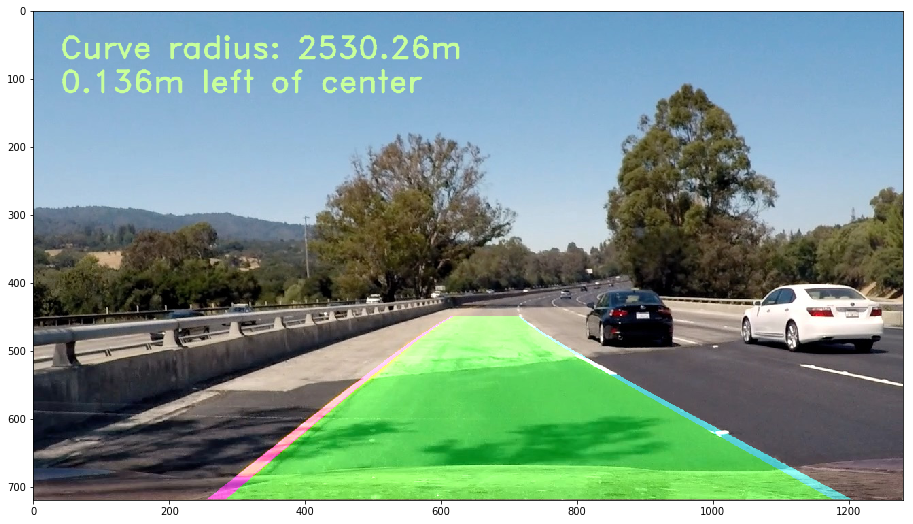

In [247]:
left_rad, right_rad, center_dist = measure_curvature_sway_real(warped_roi.shape, left_fit, right_fit)

result_unwarped = draw_lane(image, warped_roi, left_fit, right_fit, Minv)

final_result = draw_data(result_unwarped, (right_rad + left_rad) / 2, center_dist)

plt.figure(figsize=(24, 9))
plt.imshow(final_result)

### Line class

The following defines a line class that is used to maintain the state of the detected lane lines

In [273]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
        #Maintain an array of pixel count to take weigted avg later
        self.px_count_arr = []
        #margin beyond which next fit is ignored
        self.next_fit_margin = [0.001, 1.0, 100.]
        #number of max fits for averaging
        self.num_frame_fits = 5
    def add_fit(self, fit, inds):
        # add a fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > self.next_fit_margin[0] or \
               self.diffs[1] > self.next_fit_margin[1] or \
               self.diffs[2] > self.next_fit_margin[2]) and \
               len(self.current_fit) > 0:
                self.detected = False
            #if other fits are present, this fit can be ignored since it is 
            #beyond margins of prev fits
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
#                 self.px_count_arr.append(self.px_count)
                if len(self.current_fit) > self.num_frame_fits:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-self.num_frame_fits:]
#                     self.px_count_arr = self.px_count_arr[len(self.px_count_arr)-self.num_frame_fits:]
#                 self.best_fit = np.average(self.current_fit, weights=self.px_count_arr, axis=0)
                self.best_fit = np.average(self.current_fit, weights=range(len(self.current_fit), 0, -1), axis=0)

        #If you didnt get this fit, that might be because of using the last prev_fit
        #So remove that fit and try again
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
#                 self.px_count_arr = self.px_count_arr[:len(self.px_count_arr)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
#                 self.best_fit = np.average(self.current_fit, weights=self.px_count_arr, axis=0)
                self.best_fit = np.average(self.current_fit, weights=range(len(self.current_fit), 0, -1), axis=0)
#                 self.best_fit = np.average(self.current_fit, axis=0)

In [274]:
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_images_folder_path = 'test_images/*'
images_test = glob.glob(test_images_folder_path)

offset = 370
left_fit = None
right_fit = None

left_line = Line()
right_line = Line()

def process_image(image):
    
    shape = image.shape
    img_size = (shape[1], shape[0])
    
    image = dis_correct(image, *tuple(arr))
    
    bin_thresh = thresold_binary(image)
    
    warped, M, Minv = warp_img(bin_thresh, [[620, 450], [730, 450], 
                                        [1150, shape[0]], [250, shape[0]]], 
                                        offset=offset)
    
    vertices_roi = [[offset / 2, 0], [img_size[0] - offset / 2, 0], 
                                 [img_size[0]-offset / 2, img_size[1]], 
                                 [offset / 2, img_size[1]]]
    
    
    warped_roi = region_of_interest(warped, vertices_roi)
    
    if not left_line.detected or not right_line.detected:
        left_fit_prev, right_fit_prev = get_fit_coef(warped_roi, margin = 70)
    else:
        left_fit_prev, right_fit_prev = left_line.best_fit, right_line.best_fit
        
    left_fit, right_fit, left_lane_inds, right_lane_inds = search_around_poly(warped_roi, left_fit_prev, right_fit_prev, margin = 70)
    
    #the x intercept shouldn't too much more than 500
    left_fit_x_int = left_fit[0]*image.shape[0]**2 + left_fit[1]*image.shape[0] + left_fit[2]
    right_fit_x_int = right_fit[0]*image.shape[0]**2 + right_fit[1]*image.shape[0] + right_fit[2]
    x_int_diff = abs(right_fit_x_int-left_fit_x_int)
    
    left_fit_x_int = left_fit[2]
    right_fit_x_int = right_fit[2]
    x_int_diff = abs(right_fit_x_int-left_fit_x_int)
    #ignore bad fit
    if abs(500 - x_int_diff) > 100 and abs(500 - (right_fit[2] - left_fit[2])) > 100:
        left_fit = None
        right_fit = None            
    
    left_line.add_fit(left_fit, left_lane_inds)
    right_line.add_fit(right_fit, right_lane_inds)
#     result = draw_fitted_lane_lines(warped_roi, left_fit, right_fit, left_lane_inds, right_lane_inds, margin=80)
    new_img = np.copy(image)
    if left_line.best_fit is not None and right_line.best_fit is not None:
        left_rad, right_rad, center_dist = measure_curvature_sway_real(warped_roi.shape, left_line.best_fit, right_line.best_fit)

        result_unwarped = draw_lane(image, warped_roi, left_line.best_fit, right_line.best_fit, Minv)

        final_result = draw_data(result_unwarped, (right_rad + left_rad) / 2, center_dist)
    else:
        final_result = new_img
    
    return final_result

In [272]:
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<02:56,  7.14it/s]


  0%|          | 2/1261 [00:00<02:55,  7.19it/s]


  0%|          | 3/1261 [00:00<02:50,  7.36it/s]


  0%|          | 4/1261 [00:00<02:46,  7.56it/s]


  0%|          | 5/1261 [00:00<02:44,  7.62it/s]


  0%|          | 6/1261 [00:00<02:42,  7.72it/s]


  1%|          | 7/1261 [00:00<02:39,  7.88it/s]


  1%|          | 8/1261 [00:01<02:36,  8.01it/s]


  1%|          | 9/1261 [00:01<02:34,  8.12it/s]


  1%|          | 10/1261 [00:01<02:35,  8.06it/s]


  1%|          | 11/1261 [00:01<02:33,  8.13it/s]


  1%|          | 12/1261 [00:01<02:34,  8.10it/s]


  1%|          | 13/1261 [00:01<02:36,  7.99it/s]


  1%|          | 14/1261 [00:01<02:37,  7.90it/s]


  1%|          | 15/1261 [00:01<02:35,  8.02it/s]


  1%|▏         | 16/1261 [00:02<02:35,  8.03it/s]


  1%|▏         | 17/1261 [00:02<02:41,  7.68it/s]


  1%|▏         | 18/1261 [00:02<02:52,  7.22it/s]


  2%|▏         | 19/1261 [0

 11%|█         | 134/1261 [00:19<03:12,  5.86it/s]


 11%|█         | 135/1261 [00:20<03:09,  5.95it/s]


 11%|█         | 136/1261 [00:20<03:07,  6.00it/s]


 11%|█         | 137/1261 [00:20<03:04,  6.08it/s]


 11%|█         | 138/1261 [00:20<02:54,  6.43it/s]


 11%|█         | 139/1261 [00:20<02:45,  6.76it/s]


 11%|█         | 140/1261 [00:20<02:39,  7.04it/s]


 11%|█         | 141/1261 [00:20<02:32,  7.33it/s]


 11%|█▏        | 142/1261 [00:21<02:29,  7.49it/s]


 11%|█▏        | 143/1261 [00:21<02:28,  7.50it/s]


 11%|█▏        | 144/1261 [00:21<02:36,  7.15it/s]


 11%|█▏        | 145/1261 [00:21<02:43,  6.83it/s]


 12%|█▏        | 146/1261 [00:21<02:49,  6.58it/s]


 12%|█▏        | 147/1261 [00:21<02:52,  6.44it/s]


 12%|█▏        | 148/1261 [00:22<02:47,  6.65it/s]


 12%|█▏        | 149/1261 [00:22<02:47,  6.63it/s]


 12%|█▏        | 150/1261 [00:22<02:47,  6.62it/s]


 12%|█▏        | 151/1261 [00:22<02:51,  6.47it/s]


 12%|█▏        | 152/1261 [00:22<02:54,  6.34i

 21%|██        | 266/1261 [00:40<02:34,  6.43it/s]


 21%|██        | 267/1261 [00:40<02:32,  6.50it/s]


 21%|██▏       | 268/1261 [00:40<02:33,  6.45it/s]


 21%|██▏       | 269/1261 [00:40<02:25,  6.81it/s]


 21%|██▏       | 270/1261 [00:41<02:18,  7.16it/s]


 21%|██▏       | 271/1261 [00:41<02:12,  7.50it/s]


 22%|██▏       | 272/1261 [00:41<02:13,  7.43it/s]


 22%|██▏       | 273/1261 [00:41<02:18,  7.13it/s]


 22%|██▏       | 274/1261 [00:41<02:19,  7.06it/s]


 22%|██▏       | 275/1261 [00:41<02:20,  7.03it/s]


 22%|██▏       | 276/1261 [00:41<02:26,  6.75it/s]


 22%|██▏       | 277/1261 [00:42<02:27,  6.66it/s]


 22%|██▏       | 278/1261 [00:42<02:27,  6.65it/s]


 22%|██▏       | 279/1261 [00:42<02:28,  6.60it/s]


 22%|██▏       | 280/1261 [00:42<02:29,  6.55it/s]


 22%|██▏       | 281/1261 [00:42<02:27,  6.64it/s]


 22%|██▏       | 282/1261 [00:42<02:25,  6.72it/s]


 22%|██▏       | 283/1261 [00:43<02:23,  6.80it/s]


 23%|██▎       | 284/1261 [00:43<02:24,  6.75i

 32%|███▏      | 398/1261 [00:58<01:47,  8.02it/s]


 32%|███▏      | 399/1261 [00:58<01:47,  8.02it/s]


 32%|███▏      | 400/1261 [00:59<01:47,  8.04it/s]


 32%|███▏      | 401/1261 [00:59<01:46,  8.07it/s]


 32%|███▏      | 402/1261 [00:59<01:44,  8.19it/s]


 32%|███▏      | 403/1261 [00:59<01:45,  8.13it/s]


 32%|███▏      | 404/1261 [00:59<01:45,  8.11it/s]


 32%|███▏      | 405/1261 [00:59<01:44,  8.16it/s]


 32%|███▏      | 406/1261 [00:59<01:43,  8.22it/s]


 32%|███▏      | 407/1261 [00:59<01:43,  8.29it/s]


 32%|███▏      | 408/1261 [01:00<01:43,  8.26it/s]


 32%|███▏      | 409/1261 [01:00<01:44,  8.19it/s]


 33%|███▎      | 410/1261 [01:00<01:44,  8.17it/s]


 33%|███▎      | 411/1261 [01:00<01:44,  8.15it/s]


 33%|███▎      | 412/1261 [01:00<01:48,  7.84it/s]


 33%|███▎      | 413/1261 [01:00<01:48,  7.82it/s]


 33%|███▎      | 414/1261 [01:00<01:47,  7.88it/s]


 33%|███▎      | 415/1261 [01:00<01:45,  8.05it/s]


 33%|███▎      | 416/1261 [01:01<01:44,  8.11i

 42%|████▏     | 530/1261 [01:14<01:27,  8.32it/s]


 42%|████▏     | 531/1261 [01:14<01:27,  8.31it/s]


 42%|████▏     | 532/1261 [01:14<01:31,  7.97it/s]


 42%|████▏     | 533/1261 [01:14<01:34,  7.68it/s]


 42%|████▏     | 534/1261 [01:15<01:37,  7.46it/s]


 42%|████▏     | 535/1261 [01:15<01:38,  7.38it/s]


 43%|████▎     | 536/1261 [01:15<01:38,  7.32it/s]


 43%|████▎     | 537/1261 [01:15<01:34,  7.68it/s]


 43%|████▎     | 538/1261 [01:15<01:30,  7.96it/s]


 43%|████▎     | 539/1261 [01:15<01:27,  8.28it/s]


 43%|████▎     | 540/1261 [01:15<01:24,  8.52it/s]


 43%|████▎     | 541/1261 [01:15<01:23,  8.67it/s]


 43%|████▎     | 542/1261 [01:16<01:22,  8.73it/s]


 43%|████▎     | 543/1261 [01:16<01:22,  8.67it/s]


 43%|████▎     | 544/1261 [01:16<01:21,  8.84it/s]


 43%|████▎     | 545/1261 [01:16<01:19,  8.97it/s]


 43%|████▎     | 546/1261 [01:16<01:19,  9.05it/s]


 43%|████▎     | 547/1261 [01:16<01:20,  8.90it/s]


 43%|████▎     | 548/1261 [01:16<01:21,  8.76i

 52%|█████▏    | 662/1261 [01:29<01:10,  8.51it/s]


 53%|█████▎    | 663/1261 [01:30<01:10,  8.48it/s]


 53%|█████▎    | 664/1261 [01:30<01:10,  8.44it/s]


 53%|█████▎    | 665/1261 [01:30<01:09,  8.55it/s]


 53%|█████▎    | 666/1261 [01:30<01:09,  8.58it/s]


 53%|█████▎    | 667/1261 [01:30<01:08,  8.63it/s]


 53%|█████▎    | 668/1261 [01:30<01:09,  8.58it/s]


 53%|█████▎    | 669/1261 [01:30<01:08,  8.61it/s]


 53%|█████▎    | 670/1261 [01:30<01:07,  8.71it/s]


 53%|█████▎    | 671/1261 [01:31<01:07,  8.72it/s]


 53%|█████▎    | 672/1261 [01:31<01:07,  8.68it/s]


 53%|█████▎    | 673/1261 [01:31<01:07,  8.68it/s]


 53%|█████▎    | 674/1261 [01:31<01:08,  8.60it/s]


 54%|█████▎    | 675/1261 [01:31<01:08,  8.59it/s]


 54%|█████▎    | 676/1261 [01:31<01:08,  8.51it/s]


 54%|█████▎    | 677/1261 [01:31<01:08,  8.55it/s]


 54%|█████▍    | 678/1261 [01:31<01:07,  8.60it/s]


 54%|█████▍    | 679/1261 [01:31<01:07,  8.63it/s]


 54%|█████▍    | 680/1261 [01:32<01:07,  8.64i

 63%|██████▎   | 794/1261 [01:46<00:53,  8.75it/s]


 63%|██████▎   | 795/1261 [01:46<00:52,  8.89it/s]


 63%|██████▎   | 796/1261 [01:46<00:51,  8.98it/s]


 63%|██████▎   | 797/1261 [01:46<00:55,  8.37it/s]


 63%|██████▎   | 798/1261 [01:46<00:54,  8.52it/s]


 63%|██████▎   | 799/1261 [01:46<00:52,  8.78it/s]


 63%|██████▎   | 800/1261 [01:46<00:51,  8.97it/s]


 64%|██████▎   | 801/1261 [01:46<00:50,  9.07it/s]


 64%|██████▎   | 802/1261 [01:46<00:50,  9.05it/s]


 64%|██████▎   | 803/1261 [01:47<00:49,  9.18it/s]


 64%|██████▍   | 804/1261 [01:47<00:49,  9.21it/s]


 64%|██████▍   | 805/1261 [01:47<00:49,  9.23it/s]


 64%|██████▍   | 806/1261 [01:47<00:53,  8.45it/s]


 64%|██████▍   | 807/1261 [01:47<00:56,  7.97it/s]


 64%|██████▍   | 808/1261 [01:47<00:59,  7.62it/s]


 64%|██████▍   | 809/1261 [01:47<01:01,  7.33it/s]


 64%|██████▍   | 810/1261 [01:48<01:00,  7.50it/s]


 64%|██████▍   | 811/1261 [01:48<00:57,  7.78it/s]


 64%|██████▍   | 812/1261 [01:48<00:55,  8.07i

 73%|███████▎  | 926/1261 [02:01<00:40,  8.36it/s]


 74%|███████▎  | 927/1261 [02:01<00:40,  8.24it/s]


 74%|███████▎  | 928/1261 [02:01<00:39,  8.42it/s]


 74%|███████▎  | 929/1261 [02:01<00:38,  8.55it/s]


 74%|███████▍  | 930/1261 [02:01<00:39,  8.46it/s]


 74%|███████▍  | 931/1261 [02:02<00:38,  8.61it/s]


 74%|███████▍  | 932/1261 [02:02<00:37,  8.75it/s]


 74%|███████▍  | 933/1261 [02:02<00:37,  8.73it/s]


 74%|███████▍  | 934/1261 [02:02<00:37,  8.67it/s]


 74%|███████▍  | 935/1261 [02:02<00:37,  8.61it/s]


 74%|███████▍  | 936/1261 [02:02<00:38,  8.55it/s]


 74%|███████▍  | 937/1261 [02:02<00:37,  8.58it/s]


 74%|███████▍  | 938/1261 [02:02<00:37,  8.61it/s]


 74%|███████▍  | 939/1261 [02:03<00:37,  8.63it/s]


 75%|███████▍  | 940/1261 [02:03<00:37,  8.64it/s]


 75%|███████▍  | 941/1261 [02:03<00:36,  8.72it/s]


 75%|███████▍  | 942/1261 [02:03<00:37,  8.60it/s]


 75%|███████▍  | 943/1261 [02:03<00:37,  8.51it/s]


 75%|███████▍  | 944/1261 [02:03<00:36,  8.63i

 84%|████████▍ | 1057/1261 [02:16<00:24,  8.45it/s]


 84%|████████▍ | 1058/1261 [02:16<00:23,  8.67it/s]


 84%|████████▍ | 1059/1261 [02:16<00:22,  8.81it/s]


 84%|████████▍ | 1060/1261 [02:16<00:22,  8.75it/s]


 84%|████████▍ | 1061/1261 [02:17<00:22,  8.71it/s]


 84%|████████▍ | 1062/1261 [02:17<00:24,  8.20it/s]


 84%|████████▍ | 1063/1261 [02:17<00:25,  7.85it/s]


 84%|████████▍ | 1064/1261 [02:17<00:24,  7.99it/s]


 84%|████████▍ | 1065/1261 [02:17<00:24,  7.96it/s]


 85%|████████▍ | 1066/1261 [02:17<00:23,  8.22it/s]


 85%|████████▍ | 1067/1261 [02:17<00:23,  8.34it/s]


 85%|████████▍ | 1068/1261 [02:17<00:22,  8.47it/s]


 85%|████████▍ | 1069/1261 [02:18<00:22,  8.50it/s]


 85%|████████▍ | 1070/1261 [02:18<00:22,  8.51it/s]


 85%|████████▍ | 1071/1261 [02:18<00:22,  8.63it/s]


 85%|████████▌ | 1072/1261 [02:18<00:22,  8.50it/s]


 85%|████████▌ | 1073/1261 [02:18<00:22,  8.54it/s]


 85%|████████▌ | 1074/1261 [02:18<00:21,  8.53it/s]


 85%|████████▌ | 1075/1261 [

 94%|█████████▍| 1187/1261 [02:32<00:08,  8.75it/s]


 94%|█████████▍| 1188/1261 [02:32<00:08,  8.78it/s]


 94%|█████████▍| 1189/1261 [02:32<00:08,  8.88it/s]


 94%|█████████▍| 1190/1261 [02:32<00:07,  8.93it/s]


 94%|█████████▍| 1191/1261 [02:32<00:07,  8.92it/s]


 95%|█████████▍| 1192/1261 [02:33<00:07,  8.67it/s]


 95%|█████████▍| 1193/1261 [02:33<00:07,  8.63it/s]


 95%|█████████▍| 1194/1261 [02:33<00:07,  8.52it/s]


 95%|█████████▍| 1195/1261 [02:33<00:07,  8.54it/s]


 95%|█████████▍| 1196/1261 [02:33<00:07,  8.25it/s]


 95%|█████████▍| 1197/1261 [02:33<00:07,  8.15it/s]


 95%|█████████▌| 1198/1261 [02:33<00:07,  8.20it/s]


 95%|█████████▌| 1199/1261 [02:33<00:07,  8.34it/s]


 95%|█████████▌| 1200/1261 [02:33<00:07,  8.40it/s]


 95%|█████████▌| 1201/1261 [02:34<00:07,  8.30it/s]


 95%|█████████▌| 1202/1261 [02:34<00:07,  8.29it/s]


 95%|█████████▌| 1203/1261 [02:34<00:06,  8.29it/s]


 95%|█████████▌| 1204/1261 [02:34<00:07,  8.10it/s]


 96%|█████████▌| 1205/1261 [

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 21s, sys: 43.1 s, total: 4min 4s
Wall time: 2min 42s


### Pipeline (video)

Here I embed the video I have processed above

In [275]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))

### Discussion

* Most of the problems were in isolating the lane lines and accounting for the different hues of the road. The inconsitencies in the road surface give many false negatives while detecting lane lines

* There were some instances where the shadow of the bridge or the extreme sunlight gave bad detections in terms of the lane lines that were detected.

* I tried to use a weighted mean method so that I can average over previous frames using the number of pixels detected, but it didn't seem to work that well. 

* I then tried to use a weigted average by giving smaller weights to previous frames, but it doesn't seem to make a significant difference

* One can also use a stabilization algo for either skipping frames or aligning them in the video by using SIFT detectors and RANSAC (Something like a GoPro camera)